# Part 1: Define an RL Environment

In [215]:
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [216]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(9)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6

        
    def reset(self, **kwargs):
        self.index = 0
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        observation = self.state.flatten()

        info = {}

        return self.index
    
    def step(self, action):
        past = self.state.flatten()
        if action == 0:
          self.agent_pos[0] += 1
          move = 'down'
        if action == 1:
          self.agent_pos[0] -= 1
          move = 'up'
        if action == 2:
          self.agent_pos[1] += 1
          move = 'right'
        if action == 3:
          self.agent_pos[1] -= 1
          move = 'left'

        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        observation = self.state.flatten()
        reward = 0
        if np.array_equal(observation, past):
           reward = 0
        elif np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
        elif np.array_equal(self.agent_pos, [1,1]):
           reward = -2
        elif np.array_equal(self.agent_pos, [3,0]):
           reward = -5
        elif np.array_equal(self.agent_pos, [2,2]):
           reward = 2
        elif np.array_equal(self.agent_pos, [0,2]):
           reward = -2
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps or reward == 10 else False
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        self.index = self.agent_pos[0]*4+self.agent_pos[1]

        info = "Current position is: " + str(self.agent_pos) +'\nCUrrent Index:'+str(self.index) + "\nAction taken was: " + str(move) + "\nReward is: " + str(reward)
        
        return self.index, reward, terminated, info
        
    def render(self):
        output_grid = plt.grid(which = "minor")
        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.imshow(self.state)

In [217]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self):
    return np.random.choice(self.action_space.n)

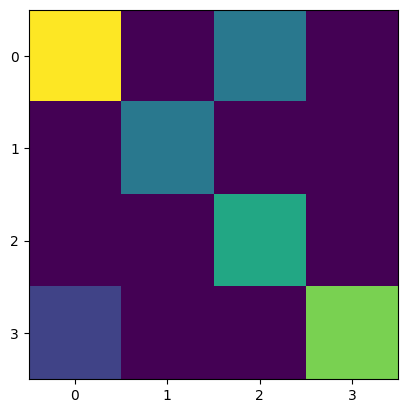

In [218]:
env = GridEnvironment()
agent = RandomAgent(env)

env.reset()

terminated, truncated = False, False
output_grid = plt.grid(which = "minor")
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3])
env.render()


Current position is: [0 0]
CUrrent Index:0
Action taken was: up
Reward is: 0


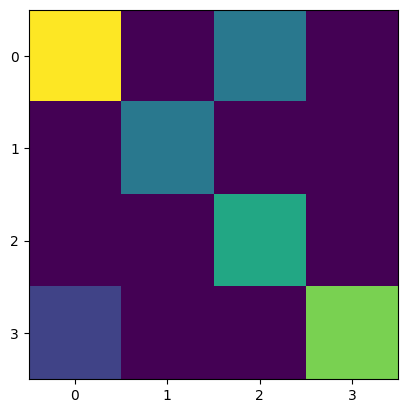

In [219]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 0]
CUrrent Index:0
Action taken was: up
Reward is: 0


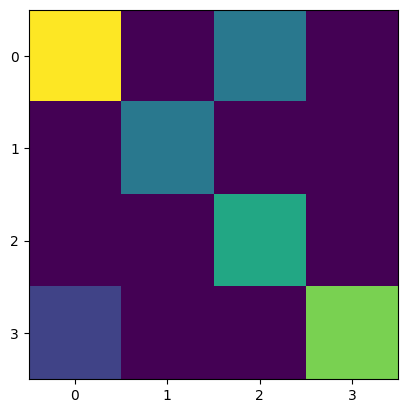

In [220]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 0]
CUrrent Index:0
Action taken was: up
Reward is: 0


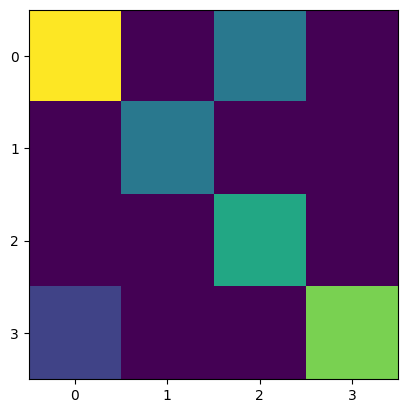

In [221]:
print(env.step(agent.step())[3])
env.render()

Current position is: [1 0]
CUrrent Index:4
Action taken was: down
Reward is: 0


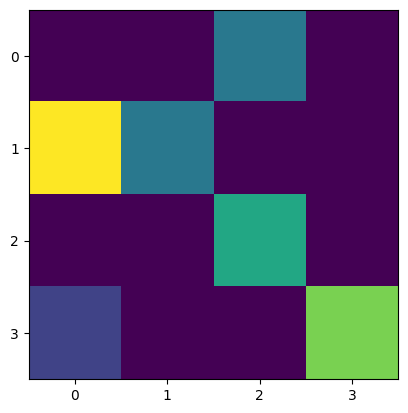

In [222]:
print(env.step(agent.step())[3])
env.render()

Current position is: [1 0]
CUrrent Index:4
Action taken was: left
Reward is: 0


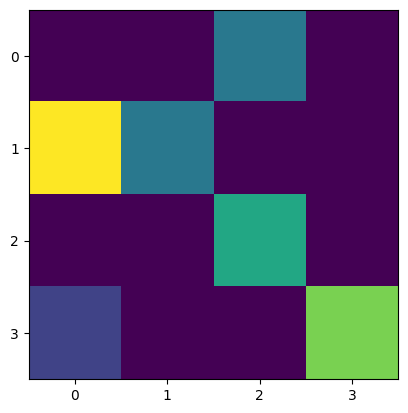

In [223]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: down
Reward is: 0


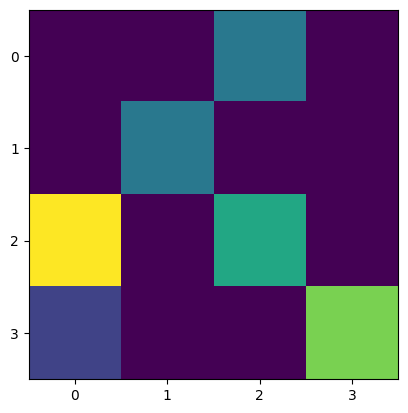

In [224]:
print(env.step(agent.step())[3])
env.render()

Current position is: [3 0]
CUrrent Index:12
Action taken was: down
Reward is: -5


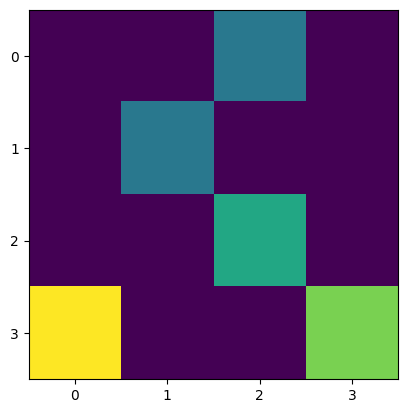

In [225]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: up
Reward is: 0


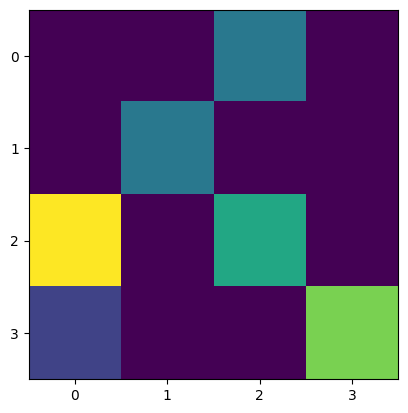

In [226]:
print(env.step(agent.step())[3])
env.render()

Current position is: [2 0]
CUrrent Index:8
Action taken was: left
Reward is: 0


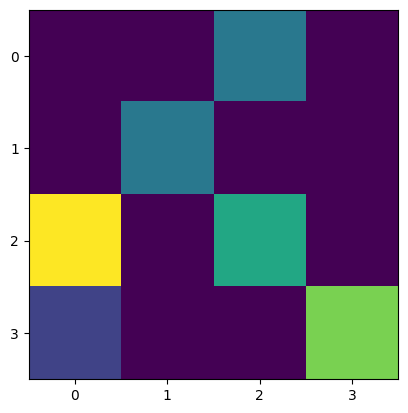

In [227]:
print(env.step(agent.step())[3])
env.render()

# Part 2: Solve your environment using - SARSA

In [228]:
epsilon = 0.75
episodes = 1000
max_steps = 20
alpha = 0.85
gamma = 0.9

Q = np.zeros((16, 4))

In [229]:
#Choose Action
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

#Update Q
def update(state1, state2, reward, action, action2):
    predict = Q[state1, action]
    target = reward + gamma * Q[state2, action2]
    Q[state1, action] = Q[state1, action] + alpha * (target - predict)

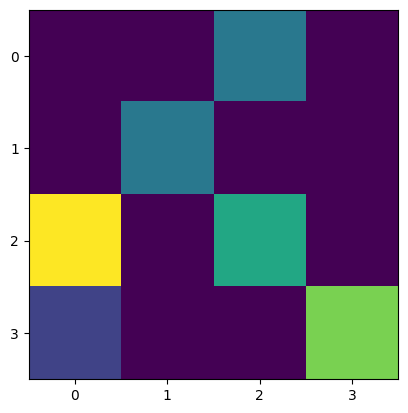

In [230]:
#Initializing the reward
reward_val=0
reward_list = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1)
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)

env.render()

In [231]:
print ("Performance : ", reward_val/episodes)

Performance :  0.319


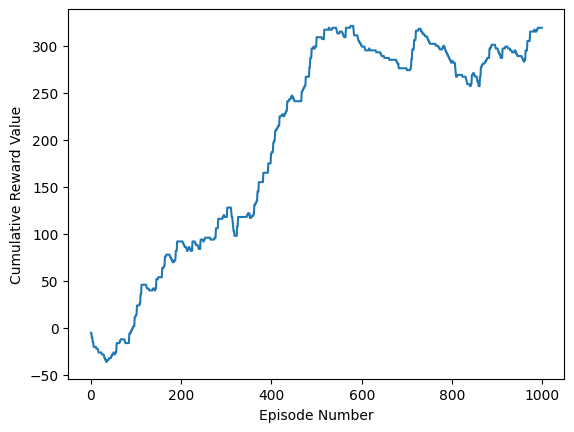

In [232]:
import matplotlib.pyplot as plt
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()